In [11]:

#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Federated Learning Comparison Study for Fraud Detection
Comparing: Full Dataset vs Single Bank vs Federated Learning

"""

# ============================================================================
# PART 1: IMPORTS AND SETUP
# ============================================================================

import os
import sys
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import xgboost as xgb
from scipy import stats

# Sklearn imports
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, 
    recall_score, f1_score, confusion_matrix, roc_curve,
    classification_report
)

# SMOTE for handling imbalanced data
from imblearn.over_sampling import SMOTE

# NVFlare imports
from nvflare import FedJob
from nvflare.app_common.workflows.etl_controller import ETLController
from nvflare.job_config.script_runner import ScriptRunner
from nvflare.app_opt.xgboost.histogram_based_v2.fed_controller import XGBFedController
from nvflare.app_opt.xgboost.histogram_based_v2.fed_executor import FedXGBHistogramExecutor

import kagglehub
import warnings
warnings.filterwarnings("ignore")




In [12]:

# ============================================================================
# PART 2: CONFIGURATION
# ============================================================================

# Download dataset
path = kagglehub.dataset_download("samayashar/fraud-detection-transactions-dataset")
input_csv = f"{path}/synthetic_fraud_dataset.csv"

# Configuration
work_dir = "/tmp/czt/jobs/workdir"
output_folder = "/tmp/czt/dataset"
metrics_dir = os.path.join(work_dir, "metrics")

# Create directories
os.makedirs(output_folder, exist_ok=True)
os.makedirs(work_dir, exist_ok=True)
os.makedirs(metrics_dir, exist_ok=True)

# Site names for federated learning
site_names = [
    "HCBHSGSG_Bank_9",
    "XITXUS33_Bank_10",
    "YSYCESMM_Bank_7",
    "YXRXGB22_Bank_3",
    "ZNZZAU3M_Bank_8",
]

PY = sys.executable

# Results storage
comparison_results = {
    "centralized_full": {},
    "single_bank": {},
    "federated": {},
    "federated_with_gnn": {}
}

print("="*70)
print("FEDERATED LEARNING COMPARISON STUDY")
print("="*70)
print(f"Working with {len(site_names)} banks for federated learning")
print(f"Output folder: {output_folder}")
print(f"Metrics folder: {metrics_dir}")


FEDERATED LEARNING COMPARISON STUDY
Working with 5 banks for federated learning
Output folder: /tmp/czt/dataset
Metrics folder: /tmp/czt/jobs/workdir/metrics


In [13]:

# ============================================================================
# PART 3: DATA PREPROCESSING FUNCTIONS
# ============================================================================

def load_and_preprocess_data(file_path, remove_outliers=True, z_threshold=3.0):
    """
    Load and preprocess data with outlier removal and feature engineering
    Similar to the successful notebook's approach
    """
    print("\nLoading and preprocessing data...")
    df = pd.read_csv(file_path)
    
    # Drop IDs
    if 'Transaction_ID' in df.columns:
        df.drop(columns=['Transaction_ID'], inplace=True)
    if 'User_ID' in df.columns:
        df.drop(columns=['User_ID'], inplace=True)
    
    # Convert Timestamp to datetime and extract features
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Hour'] = df['Timestamp'].dt.hour
    df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
    df['Month'] = df['Timestamp'].dt.month
    df['Day'] = df['Timestamp'].dt.day
    df['Is_Weekend'] = (df['DayOfWeek'] >= 5).astype(int)
    
    # Create derived features before dropping columns
    if 'Daily_Transaction_Count' in df.columns and 'Avg_Transaction_Amount_7d' in df.columns:
        df['Transaction_Ratio'] = df['Daily_Transaction_Count'] / (df['Avg_Transaction_Amount_7d'] + 1)
    
    if 'Failed_Transaction_Count_7d' in df.columns and 'Daily_Transaction_Count' in df.columns:
        df['Failed_Transaction_Rate'] = df['Failed_Transaction_Count_7d'] / (df['Daily_Transaction_Count'] + 1)
    
    if 'Previous_Fraudulent_Activity' in df.columns and 'Card_Age' in df.columns:
        df['Fraud_History_Impact'] = df['Previous_Fraudulent_Activity'] / (df['Card_Age'] + 1)
    
    # Drop original Timestamp
    df.drop(columns=['Timestamp'], inplace=True, errors='ignore')
    
    # Remove outliers using Z-score if requested
    if remove_outliers:
        print(f"Removing outliers with Z-score threshold: {z_threshold}")
        original_shape = df.shape
        
        # Select numerical columns (excluding target)
        num_cols = df.select_dtypes(include=['number']).columns
        num_cols = [col for col in num_cols if col != 'Fraud_Label']
        
        # Calculate Z-scores for each numerical column
        for col in num_cols:
            z_scores = np.abs(stats.zscore(df[col]))
            df = df[z_scores <= z_threshold]
        
        print(f"  Original shape: {original_shape}")
        print(f"  After outlier removal: {df.shape}")
        print(f"  Removed {original_shape[0] - df.shape[0]} rows ({(original_shape[0] - df.shape[0])/original_shape[0]*100:.2f}%)")
    
    # Remove Risk_Score if present (data leakage)
    if 'Risk_Score' in df.columns:
        print("  Removing Risk_Score column (potential data leakage)")
        df.drop(columns=['Risk_Score'], inplace=True)
    
    return df

def encode_categorical_features(df):
    """
    Encode categorical features using LabelEncoder
    """
    categorical_columns = df.select_dtypes(include=['object']).columns
    label_encoders = {}
    
    for col in categorical_columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le
    
    return df, label_encoders

def prepare_features_and_target(df):
    """
    Separate features and target, apply StandardScaler
    """
    X = df.drop(columns=['Fraud_Label'])
    y = df['Fraud_Label']
    
    return X, y

def apply_smote_and_scale(X_train, y_train, X_test, random_state=42):
    """
    Apply SMOTE for class balancing and StandardScaler for normalization
    """
    # Apply StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Apply SMOTE to training data only
    smote = SMOTE(random_state=random_state)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
    
    print(f"  Original training set: {len(y_train)} samples")
    print(f"  After SMOTE: {len(y_train_resampled)} samples")
    print(f"  Class distribution after SMOTE: {np.bincount(y_train_resampled)}")
    
    return X_train_resampled, y_train_resampled, X_test_scaled, scaler


In [14]:

# ============================================================================
# PART 4: MODEL TRAINING AND EVALUATION FUNCTIONS
# ============================================================================

def train_xgboost_model(X_train, y_train, X_test, y_test, model_name="Model"):
    """
    Train XGBoost model with proper parameters for fraud detection
    """
    print(f"\nTraining {model_name}...")
    
    # Create DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    # Parameters optimized for fraud detection
    params = {
        "max_depth": 8,
        "eta": 0.1,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "tree_method": "hist",
        "scale_pos_weight": 1,  # Already balanced with SMOTE
        "nthread": 6,
    }
    
    # Train model
    evals = [(dtrain, "train"), (dtest, "test")]
    evals_result = {}
    
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=100,
        evals=evals,
        evals_result=evals_result,
        early_stopping_rounds=10,
        verbose_eval=20
    )
    
    # Make predictions
    y_prob = model.predict(dtest)
    y_pred = (y_prob > 0.5).astype(int)
    
    # Calculate metrics
    metrics = {
        "auc": roc_auc_score(y_test, y_prob),
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "confusion_matrix": confusion_matrix(y_test, y_pred),
        "best_iteration": model.best_iteration,
        "training_history": evals_result
    }
    
    print(f"\n{model_name} Results:")
    print(f"  AUC: {metrics['auc']:.4f}")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  F1: {metrics['f1']:.4f}")
    print(f"  Best iteration: {metrics['best_iteration']}")
    
    return model, metrics, y_prob


In [15]:

# ============================================================================
# PART 5: CENTRALIZED MODEL (FULL DATASET)
# ============================================================================

print("\n" + "="*70)
print("APPROACH 1: CENTRALIZED MODEL WITH FULL DATASET")
print("="*70)

# Load and preprocess full dataset
df_full = load_and_preprocess_data(input_csv, remove_outliers=False, z_threshold=3.0)

# Encode categorical features
df_full_encoded, label_encoders = encode_categorical_features(df_full.copy())

# Prepare features and target
X_full, y_full = prepare_features_and_target(df_full_encoded)

# Split data
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

print(f"\nFull dataset shape: {X_full.shape}")
print(f"Training set: {X_train_full.shape}")
print(f"Test set: {X_test_full.shape}")
print(f"Fraud rate in training: {y_train_full.mean():.2%}")
print(f"Fraud rate in test: {y_test_full.mean():.2%}")

# Apply SMOTE and scaling
X_train_full_processed, y_train_full_processed, X_test_full_processed, scaler_full = apply_smote_and_scale(
    X_train_full, y_train_full, X_test_full
)

# Train centralized model
model_centralized, metrics_centralized, y_prob_centralized = train_xgboost_model(
    X_train_full_processed, y_train_full_processed,
    X_test_full_processed, y_test_full,
    model_name="Centralized Model"
)

comparison_results["centralized_full"] = metrics_centralized



APPROACH 1: CENTRALIZED MODEL WITH FULL DATASET

Loading and preprocessing data...
  Removing Risk_Score column (potential data leakage)

Full dataset shape: (50000, 23)
Training set: (40000, 23)
Test set: (10000, 23)
Fraud rate in training: 32.14%
Fraud rate in test: 32.13%
  Original training set: 40000 samples
  After SMOTE: 54292 samples
  Class distribution after SMOTE: [27146 27146]

Training Centralized Model...
[0]	train-auc:0.89702	test-auc:0.81130
[12]	train-auc:0.93247	test-auc:0.81418

Centralized Model Results:
  AUC: 0.8142
  Accuracy: 0.8772
  Precision: 1.0000
  Recall: 0.6178
  F1: 0.7638
  Best iteration: 2


In [16]:

# ============================================================================
# PART 6: SINGLE BANK MODEL
# ============================================================================

print("\n" + "="*70)
print("APPROACH 2: SINGLE BANK MODEL")
print("="*70)

# First, prepare the data with bank assignments (run prepare_data.py)
print("\nPreparing data with bank assignments...")
os.system(f"{PY} ./utils/prepare_data.py -i {input_csv} -o {output_folder}")

# Select the first bank for single bank analysis
selected_bank = site_names[0]  # You can change this to test different banks
print(f"\nUsing {selected_bank} for single bank analysis")

# Load single bank data
train_file = os.path.join(output_folder, selected_bank, "train.csv")
test_file = os.path.join(output_folder, selected_bank, "test.csv")

if os.path.exists(train_file) and os.path.exists(test_file):
    df_bank_train = pd.read_csv(train_file)
    df_bank_test = pd.read_csv(test_file)
    
    # Combine for preprocessing
    df_bank = pd.concat([df_bank_train, df_bank_test], ignore_index=True)
    
    # Preprocess
    df_bank = load_and_preprocess_data(train_file, remove_outliers=False, z_threshold=3.0)
    df_bank_test_processed = load_and_preprocess_data(test_file, remove_outliers=False, z_threshold=3.0)
    
    # Encode
    df_bank_encoded, _ = encode_categorical_features(df_bank.copy())
    df_bank_test_encoded, _ = encode_categorical_features(df_bank_test_processed.copy())
    
    # Prepare features
    X_train_bank, y_train_bank = prepare_features_and_target(df_bank_encoded)
    X_test_bank, y_test_bank = prepare_features_and_target(df_bank_test_encoded)
    
    print(f"\nSingle bank dataset shape: {X_train_bank.shape}")
    print(f"Training samples: {len(y_train_bank)}")
    print(f"Test samples: {len(y_test_bank)}")
    print(f"Fraud rate in training: {y_train_bank.mean():.2%}")
    print(f"Fraud rate in test: {y_test_bank.mean():.2%}")
    
    # Apply SMOTE and scaling
    X_train_bank_processed, y_train_bank_processed, X_test_bank_processed, scaler_bank = apply_smote_and_scale(
        X_train_bank, y_train_bank, X_test_bank
    )
    
    # Train single bank model
    model_bank, metrics_bank, y_prob_bank = train_xgboost_model(
        X_train_bank_processed, y_train_bank_processed,
        X_test_bank_processed, y_test_bank,
        model_name="Single Bank Model"
    )
    
    comparison_results["single_bank"] = metrics_bank
else:
    print(f"Error: Could not find data files for {selected_bank}")



APPROACH 2: SINGLE BANK MODEL

Preparing data with bank assignments...
Historical DataFrame size: 27500
Training DataFrame size: 17500
Testing DataFrame size: 5000
Saved HCBHSGSG history transactions to /tmp/czt/dataset/HCBHSGSG_Bank_9/history.csv
Saved XITXUS33 history transactions to /tmp/czt/dataset/XITXUS33_Bank_10/history.csv
Saved YSYCESMM history transactions to /tmp/czt/dataset/YSYCESMM_Bank_7/history.csv
Saved YXRXGB22 history transactions to /tmp/czt/dataset/YXRXGB22_Bank_3/history.csv
Saved ZNZZAU3M history transactions to /tmp/czt/dataset/ZNZZAU3M_Bank_8/history.csv
Saved HCBHSGSG train transactions to /tmp/czt/dataset/HCBHSGSG_Bank_9/train.csv
Saved XITXUS33 train transactions to /tmp/czt/dataset/XITXUS33_Bank_10/train.csv
Saved YSYCESMM train transactions to /tmp/czt/dataset/YSYCESMM_Bank_7/train.csv
Saved YXRXGB22 train transactions to /tmp/czt/dataset/YXRXGB22_Bank_3/train.csv
Saved ZNZZAU3M train transactions to /tmp/czt/dataset/ZNZZAU3M_Bank_8/train.csv
Saved HCBHSGS

In [19]:
# ============================================================================
# PART 7: FEDERATED MODEL EVALUATION (WITHOUT GNN)
# ============================================================================

print("\n" + "="*70)
print("FEDERATED MODEL (WITHOUT GNN)")
print("="*70)

# Path to saved federated model
fed_model_path = "./saved_models/credit_fraud/xgb_model_bank3.json"

# Check if model exists
if not os.path.exists(fed_model_path):
    print(f"WARNING: Federated model not found at {fed_model_path}")
    print("Please ensure the federated training has been completed first.")
    fed_metrics = None
else:
    # Load the CORRECT test data for federated model
    fed_test_file = "/tmp/czt/dataset/YXRXGB22_Bank_3/test_normalized.csv"
    
    if not os.path.exists(fed_test_file):
        print(f"ERROR: Federated test file not found at {fed_test_file}")
        print("Please run the federated pipeline first to generate test data.")
        fed_metrics = None
    else:
        print(f"Loading federated test data from: {fed_test_file}")
        df_fed_test = pd.read_csv(fed_test_file)
        
        # Clean up data
        if 'Unnamed: 0' in df_fed_test.columns:
            df_fed_test = df_fed_test.drop(columns=['Unnamed: 0'])
        if 'Transaction_ID' in df_fed_test.columns:
            df_fed_test = df_fed_test.drop(columns=['Transaction_ID'])
        
        # Separate features and target
        if "Fraud_Label" in df_fed_test.columns:
            y_test_fed = df_fed_test["Fraud_Label"]
            X_test_fed = df_fed_test.drop(columns=["Fraud_Label"])
        else:
            y_test_fed = df_fed_test.iloc[:, -1]
            X_test_fed = df_fed_test.iloc[:, :-1]
        
        print(f"Test data shape: {X_test_fed.shape}")
        print(f"Fraud rate: {y_test_fed.mean():.2%}")
        
        # Load model
        fed_model = xgb.Booster()
        fed_model.load_model(fed_model_path)
        
        # Check feature count
        if fed_model.num_features() != X_test_fed.shape[1]:
            print(f"ERROR: Feature mismatch! Model expects {fed_model.num_features()} but got {X_test_fed.shape[1]}")
            fed_metrics = None
        else:
            # Make predictions
            dtest = xgb.DMatrix(X_test_fed, label=y_test_fed)
            y_prob_fed = fed_model.predict(dtest)
            y_pred_fed = (y_prob_fed > 0.5).astype(int)
            
            # Calculate metrics
            fed_metrics = {
                "auc": roc_auc_score(y_test_fed, y_prob_fed),
                "accuracy": accuracy_score(y_test_fed, y_pred_fed),
                "precision": precision_score(y_test_fed, y_pred_fed, zero_division=0),
                "recall": recall_score(y_test_fed, y_pred_fed, zero_division=0),
                "f1": f1_score(y_test_fed, y_pred_fed, zero_division=0),
                "confusion_matrix": confusion_matrix(y_test_fed, y_pred_fed),
                "y_prob": y_prob_fed,
                "y_pred": y_pred_fed
            }
            
            print(f"\nFederated Model Performance:")
            print(f"  AUC: {fed_metrics['auc']:.4f}")
            print(f"  Accuracy: {fed_metrics['accuracy']:.4f}")
            print(f"  Precision: {fed_metrics['precision']:.4f}")
            print(f"  Recall: {fed_metrics['recall']:.4f}")
            print(f"  F1: {fed_metrics['f1']:.4f}")
            
            tn, fp, fn, tp = fed_metrics["confusion_matrix"].ravel()
            print(f"\nConfusion Matrix:")
            print(f"  TN: {tn:6d}  FP: {fp:6d}")
            print(f"  FN: {fn:6d}  TP: {tp:6d}")

if fed_metrics:
    comparison_results["federated"] = fed_metrics





FEDERATED MODEL (WITHOUT GNN)
Loading federated test data from: /tmp/czt/dataset/YXRXGB22_Bank_3/test_normalized.csv
Test data shape: (954, 28)
Fraud rate: 35.43%

Federated Model Performance:
  AUC: 0.7559
  Accuracy: 0.7610
  Precision: 0.6993
  Recall: 0.5710
  F1: 0.6287

Confusion Matrix:
  TN:    533  FP:     83
  FN:    145  TP:    193


In [21]:
# ============================================================================
# PART 8: FEDERATED MODEL WITH GNN EVALUATION
# ============================================================================

print("\n" + "="*70)
print("FEDERATED MODEL WITH GNN FEATURES")
print("="*70)

# Path to saved federated GNN model
fed_gnn_model_path = "./saved_models/xgb_gnn_model_bank3.json"

# Check if model exists
if not os.path.exists(fed_gnn_model_path):
    print(f"WARNING: Federated GNN model not found at {fed_gnn_model_path}")
    print("Please ensure the federated GNN training has been completed first.")
    fed_gnn_metrics = None
else:
    # Load the CORRECT test data for federated GNN model
    fed_gnn_test_file = "/tmp/czt/dataset/YXRXGB22_Bank_3/test_combined.csv"
    
    if not os.path.exists(fed_gnn_test_file):
        print(f"ERROR: Federated GNN test file not found at {fed_gnn_test_file}")
        print("Please run the federated GNN pipeline first to generate test data.")
        fed_gnn_metrics = None
    else:
        print(f"Loading federated GNN test data from: {fed_gnn_test_file}")
        df_fed_gnn_test = pd.read_csv(fed_gnn_test_file)
        
        # Clean up data
        if 'Unnamed: 0' in df_fed_gnn_test.columns:
            df_fed_gnn_test = df_fed_gnn_test.drop(columns=['Unnamed: 0'])
        if 'Transaction_ID' in df_fed_gnn_test.columns:
            df_fed_gnn_test = df_fed_gnn_test.drop(columns=['Transaction_ID'])
        
        # Separate features and target
        if "Fraud_Label" in df_fed_gnn_test.columns:
            y_test_gnn = df_fed_gnn_test["Fraud_Label"]
            X_test_gnn = df_fed_gnn_test.drop(columns=["Fraud_Label"])
        else:
            y_test_gnn = df_fed_gnn_test.iloc[:, -1]
            X_test_gnn = df_fed_gnn_test.iloc[:, :-1]
        
        print(f"Test data shape: {X_test_gnn.shape}")
        print(f"Fraud rate: {y_test_gnn.mean():.2%}")
        
        # Identify GNN columns
        gnn_cols = [col for col in X_test_gnn.columns if col.startswith('V_')]
        print(f"GNN embedding dimensions: {len(gnn_cols)}")
        
        # Load model
        fed_gnn_model = xgb.Booster()
        fed_gnn_model.load_model(fed_gnn_model_path)
        
        # Check feature count
        if fed_gnn_model.num_features() != X_test_gnn.shape[1]:
            print(f"ERROR: Feature mismatch! Model expects {fed_gnn_model.num_features()} but got {X_test_gnn.shape[1]}")
            fed_gnn_metrics = None
        else:
            # Make predictions
            dtest = xgb.DMatrix(X_test_gnn, label=y_test_gnn)
            y_prob_gnn = fed_gnn_model.predict(dtest)
            y_pred_gnn = (y_prob_gnn > 0.5).astype(int)
            
            # Calculate metrics
            fed_gnn_metrics = {
                "auc": roc_auc_score(y_test_gnn, y_prob_gnn),
                "accuracy": accuracy_score(y_test_gnn, y_pred_gnn),
                "precision": precision_score(y_test_gnn, y_pred_gnn, zero_division=0),
                "recall": recall_score(y_test_gnn, y_pred_gnn, zero_division=0),
                "f1": f1_score(y_test_gnn, y_pred_gnn, zero_division=0),
                "confusion_matrix": confusion_matrix(y_test_gnn, y_pred_gnn),
                "y_prob": y_prob_gnn,
                "y_pred": y_pred_gnn
            }
            
            print(f"\nFederated GNN Model Performance:")
            print(f"  AUC: {fed_gnn_metrics['auc']:.4f}")
            print(f"  Accuracy: {fed_gnn_metrics['accuracy']:.4f}")
            print(f"  Precision: {fed_gnn_metrics['precision']:.4f}")
            print(f"  Recall: {fed_gnn_metrics['recall']:.4f}")
            print(f"  F1: {fed_gnn_metrics['f1']:.4f}")
            
            tn, fp, fn, tp = fed_gnn_metrics["confusion_matrix"].ravel()
            print(f"\nConfusion Matrix:")
            print(f"  TN: {tn:6d}  FP: {fp:6d}")
            print(f"  FN: {fn:6d}  TP: {tp:6d}")

if fed_gnn_metrics:
    comparison_results["federated_with_gnn"] = fed_gnn_metrics


FEDERATED MODEL WITH GNN FEATURES
Loading federated GNN test data from: /tmp/czt/dataset/YXRXGB22_Bank_3/test_combined.csv
Test data shape: (958, 61)
Fraud rate: 35.28%
GNN embedding dimensions: 32

Federated GNN Model Performance:
  AUC: 0.7955
  Accuracy: 0.7693
  Precision: 0.9466
  Recall: 0.3669
  F1: 0.5288

Confusion Matrix:
  TN:    613  FP:      7
  FN:    214  TP:    124



FEDERATED LEARNING EVALUATION STUDY

MODEL PERFORMANCE SUMMARY

Performance Metrics:
             Model  Test Samples      AUC  Accuracy  Precision   Recall  F1 Score
  Centralized Full         10000 0.814177  0.877200   1.000000 0.617803  0.763755
       Single Bank          1002 0.797674  0.804391   0.706485 0.652997  0.678689
Federated With Gnn           958 0.795524  0.769311   0.946565 0.366864  0.528785
         Federated           954 0.755893  0.761006   0.699275 0.571006  0.628664


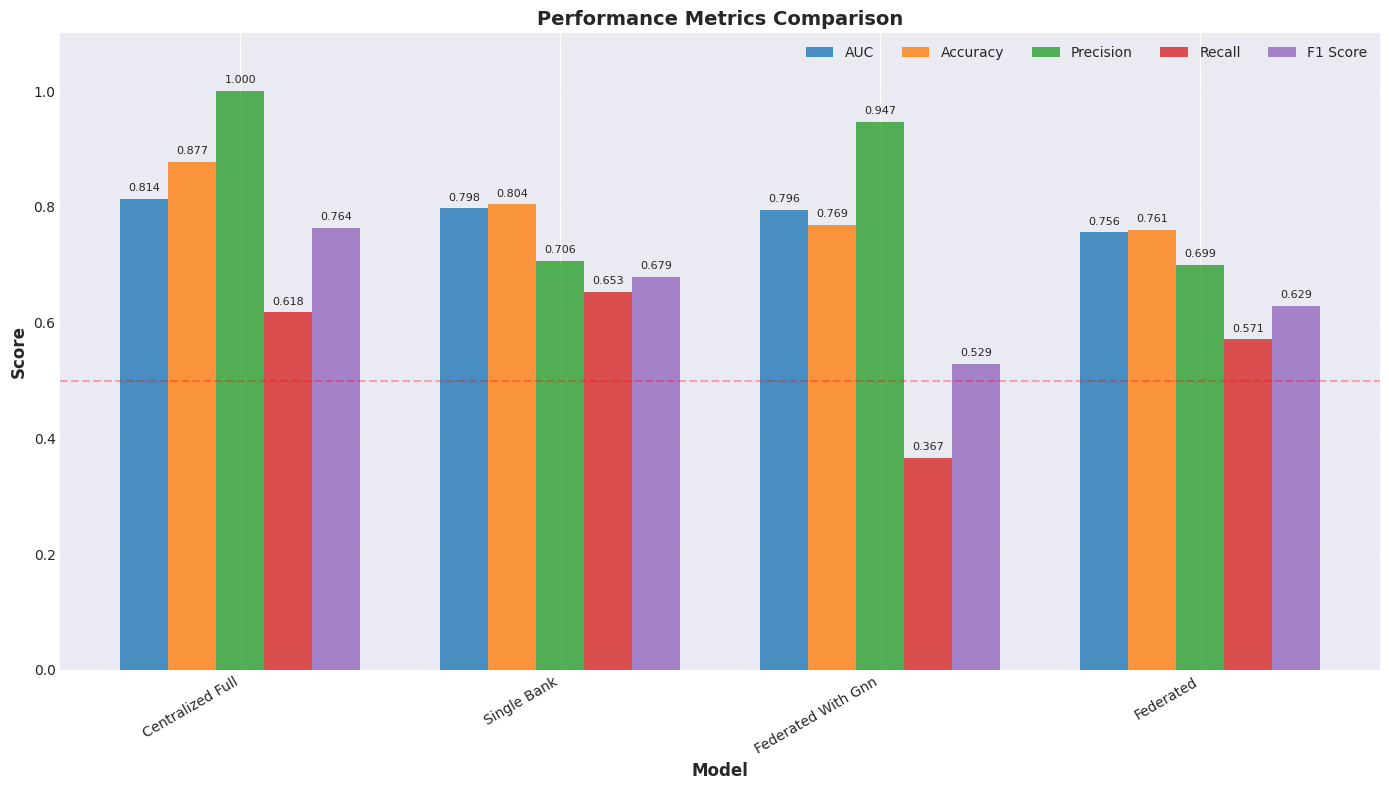

✓ Metrics comparison saved to: /tmp/czt/jobs/workdir/metrics/metrics_comparison.png

FEDERATED LEARNING ANALYSIS

1. AVERAGE PERFORMANCE BY APPROACH:
----------------------------------------
Metric              Baseline    Federated   Difference
----------------------------------------
AUC                   0.8059       0.7757     -0.0302 (-3.7%)
ACCURACY              0.8408       0.7652     -0.0756 (-9.0%)
PRECISION             0.8532       0.8229     -0.0303 (-3.6%)
RECALL                0.6354       0.4689     -0.1665 (-26.2%)
F1                    0.7212       0.5787     -0.1425 (-19.8%)

2. INDIVIDUAL MODEL PERFORMANCE:
----------------------------------------

Centralized Full (Baseline):
  AUC:       0.8142
  F1 Score:  0.7638
  Sensitivity: 0.6178 (fraud detection rate)
  Specificity: 1.0000 (non-fraud accuracy)
  Samples:     10,000

Single Bank (Baseline):
  AUC:       0.7977
  F1 Score:  0.6787
  Sensitivity: 0.6530 (fraud detection rate)
  Specificity: 0.8745 (non-fraud acc

In [ ]:
# ============================================================================
# PART 9: COMPREHENSIVE MODEL EVALUATION AND COMPARISON
# ============================================================================

print("\n" + "="*70)
print("FEDERATED LEARNING EVALUATION STUDY")
print("="*70)

# Ensure metrics directory exists
os.makedirs(metrics_dir, exist_ok=True)

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ============================================================================
# 9.1: Create Summary Table
# ============================================================================

def create_comparison_summary():
    """Create a summary table of all model performances"""
    
    print("\n" + "="*50)
    print("MODEL PERFORMANCE SUMMARY")
    print("="*50)
    
    summary_data = []
    
    for model_name, metrics in comparison_results.items():
        if metrics and isinstance(metrics, dict):
            # Get confusion matrix values
            if 'confusion_matrix' in metrics:
                cm = metrics['confusion_matrix']
                tn, fp, fn, tp = cm.ravel()
                total = cm.sum()
                
                row = {
                    'Model': model_name.replace('_', ' ').title(),
                    'Test Samples': total,
                    'AUC': metrics.get('auc', 0),
                    'Accuracy': metrics.get('accuracy', 0),
                    'Precision': metrics.get('precision', 0),
                    'Recall': metrics.get('recall', 0),
                    'F1 Score': metrics.get('f1', 0),
                    'True Positives': tp,
                    'False Positives': fp,
                    'True Negatives': tn,
                    'False Negatives': fn
                }
                summary_data.append(row)
    
    df_summary = pd.DataFrame(summary_data)
    
    if not df_summary.empty:
        # Sort by AUC
        df_summary = df_summary.sort_values('AUC', ascending=False)
        
        print("\nPerformance Metrics:")
        print(df_summary[['Model', 'Test Samples', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1 Score']].to_string(index=False))
        
        # Save to CSV
        df_summary.to_csv(os.path.join(metrics_dir, 'model_summary.csv'), index=False)
        
    return df_summary

df_summary = create_comparison_summary()

# ============================================================================
# 9.2: Confusion Matrices Visualization
# ============================================================================

def plot_detailed_confusion_matrices():
    """Create detailed confusion matrices with raw counts"""
    
    models_to_plot = list(comparison_results.items())
    n_models = len([m for m in models_to_plot if m[1] is not None])
    
    if n_models == 0:
        print("No models to plot")
        return
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()
    
    for idx, (model_name, metrics) in enumerate(models_to_plot):
        if idx >= 4:  # Only plot first 4 models
            break
            
        if metrics and 'confusion_matrix' in metrics:
            cm = metrics['confusion_matrix']
            
            # Create annotation text with raw counts
            annot = np.array([[f'{cm[i,j]:,}' for j in range(2)] for i in range(2)])
            
            # Plot heatmap
            sns.heatmap(cm, annot=annot, fmt='', cmap='Blues',
                       ax=axes[idx], cbar=True,
                       xticklabels=['Predicted\nNon-Fraud', 'Predicted\nFraud'],
                       yticklabels=['Actual\nNon-Fraud', 'Actual\nFraud'],
                       cbar_kws={'label': 'Count'})
            
            # Add title with key metrics
            title = f"{model_name.replace('_', ' ').title()}\n"
            title += f"AUC: {metrics.get('auc', 0):.3f} | "
            title += f"Acc: {metrics.get('accuracy', 0):.3f} | "
            title += f"F1: {metrics.get('f1', 0):.3f}"
            axes[idx].set_title(title, fontsize=11, fontweight='bold')
            
            # Add metrics below the heatmap
            total = cm.sum()
            axes[idx].text(0.5, -0.12, f'Total Samples: {total:,}',
                         transform=axes[idx].transAxes,
                         ha='center', fontsize=9)
    
    # Hide unused subplots
    for idx in range(n_models, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Confusion Matrices Comparison', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(metrics_dir, 'confusion_matrices_detailed.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Confusion matrices saved to:", os.path.join(metrics_dir, 'confusion_matrices_detailed.png'))

plot_detailed_confusion_matrices()


# ============================================================================
# 9.3: Performance Metrics Bar Chart
# ============================================================================

def plot_metrics_comparison():
    """Create grouped bar chart comparing key metrics"""
    
    if df_summary.empty:
        print("No data for metrics comparison")
        return
    
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Prepare data
    models = df_summary['Model'].values
    x = np.arange(len(models))
    width = 0.15
    
    metrics = ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1 Score']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    # Plot bars
    for i, metric in enumerate(metrics):
        offset = width * (i - 2)  # Center the bars
        values = df_summary[metric].values
        bars = ax.bar(x + offset, values, width, label=metric, color=colors[i], alpha=0.8)
        
        # Add value labels on bars
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{value:.3f}', ha='center', va='bottom', fontsize=8)
    
    # Customize plot
    ax.set_xlabel('Model', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=30, ha='right')
    ax.legend(loc='upper right', ncol=5, fontsize=10)
    ax.grid(True, axis='y', alpha=0.3)
    ax.set_ylim([0, 1.1])
    
    # Add horizontal line at 0.5 (random baseline)
    ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.3, label='Random Baseline')
    
    plt.tight_layout()
    plt.savefig(os.path.join(metrics_dir, 'metrics_comparison.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Metrics comparison saved to:", os.path.join(metrics_dir, 'metrics_comparison.png'))

plot_metrics_comparison()

# ============================================================================
# 9.4: Federated vs Baseline Analysis
# ============================================================================

def analyze_federated_performance():
    """Specific analysis comparing federated models to baselines"""
    
    print("\n" + "="*50)
    print("FEDERATED LEARNING ANALYSIS")
    print("="*50)
    
    # Identify model types
    baseline_models = ['centralized_full', 'single_bank']
    federated_models = ['federated', 'federated_with_gnn']
    
    # Calculate average performance for each group
    baseline_metrics = {}
    federated_metrics = {}
    
    for metric in ['auc', 'accuracy', 'precision', 'recall', 'f1']:
        baseline_vals = [comparison_results[m].get(metric, 0) for m in baseline_models 
                        if m in comparison_results and comparison_results[m]]
        federated_vals = [comparison_results[m].get(metric, 0) for m in federated_models 
                         if m in comparison_results and comparison_results[m]]
        
        if baseline_vals:
            baseline_metrics[metric] = np.mean(baseline_vals)
        if federated_vals:
            federated_metrics[metric] = np.mean(federated_vals)
    
    # Print comparison
    print("\n1. AVERAGE PERFORMANCE BY APPROACH:")
    print("-" * 40)
    print(f"{'Metric':<15} {'Baseline':>12} {'Federated':>12} {'Difference':>12}")
    print("-" * 40)
    
    for metric in ['auc', 'accuracy', 'precision', 'recall', 'f1']:
        baseline_val = baseline_metrics.get(metric, 0)
        federated_val = federated_metrics.get(metric, 0)
        diff = federated_val - baseline_val
        diff_pct = (diff / baseline_val * 100) if baseline_val > 0 else 0
        
        print(f"{metric.upper():<15} {baseline_val:>12.4f} {federated_val:>12.4f} {diff:+11.4f} ({diff_pct:+.1f}%)")
    
    # Individual model analysis
    print("\n2. INDIVIDUAL MODEL PERFORMANCE:")
    print("-" * 40)
    
    for model_name in comparison_results:
        if comparison_results[model_name]:
            metrics = comparison_results[model_name]
            model_type = "Federated" if model_name in federated_models else "Baseline"
            
            print(f"\n{model_name.replace('_', ' ').title()} ({model_type}):")
            print(f"  AUC:       {metrics.get('auc', 0):.4f}")
            print(f"  F1 Score:  {metrics.get('f1', 0):.4f}")
            
            if 'confusion_matrix' in metrics:
                cm = metrics['confusion_matrix']
                tn, fp, fn, tp = cm.ravel()
                
                # Calculate additional metrics
                specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
                sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
                
                print(f"  Sensitivity: {sensitivity:.4f} (fraud detection rate)")
                print(f"  Specificity: {specificity:.4f} (non-fraud accuracy)")
                print(f"  Samples:     {cm.sum():,}")
    
    # GNN Enhancement Analysis
    if 'federated' in comparison_results and 'federated_with_gnn' in comparison_results:
        if comparison_results['federated'] and comparison_results['federated_with_gnn']:
            print("\n3. GNN FEATURE ENHANCEMENT:")
            print("-" * 40)
            
            for metric in ['auc', 'accuracy', 'precision', 'recall', 'f1']:
                base_val = comparison_results['federated'].get(metric, 0)
                gnn_val = comparison_results['federated_with_gnn'].get(metric, 0)
                improvement = gnn_val - base_val
                improvement_pct = (improvement / base_val * 100) if base_val > 0 else 0
                
                print(f"{metric.upper():<10}: {base_val:.4f} → {gnn_val:.4f} ({improvement_pct:+.1f}%)")

analyze_federated_performance()

# ============================================================================
# 9.5: Error Analysis
# ============================================================================

def perform_error_analysis():
    """Analyze false positives and false negatives"""
    
    print("\n" + "="*50)
    print("ERROR ANALYSIS")
    print("="*50)
    
    for model_name, metrics in comparison_results.items():
        if metrics and 'confusion_matrix' in metrics:
            cm = metrics['confusion_matrix']
            tn, fp, fn, tp = cm.ravel()
            total = cm.sum()
            
            print(f"\n{model_name.replace('_', ' ').title()}:")
            print(f"  False Positive Rate: {fp/(fp+tn):.3f} ({fp:,}/{fp+tn:,})")
            print(f"  False Negative Rate: {fn/(fn+tp):.3f} ({fn:,}/{fn+tp:,})")
            print(f"  Error Rate: {(fp+fn)/total:.3f} ({fp+fn:,}/{total:,})")
            
            # Business impact
            fraud_cost = 100  # Cost of missing a fraud
            false_alarm_cost = 10  # Cost of false alarm
            total_cost = fn * fraud_cost + fp * false_alarm_cost
            print(f"  Estimated Cost (arbitrary units): {total_cost:,}")

perform_error_analysis()

# ============================================================================
# 9.6: Summary and Recommendations
# ============================================================================

print("\n" + "="*70)
print("SUMMARY AND RECOMMENDATIONS")
print("="*70)

print("\nKEY FINDINGS:")
print("-" * 40)

# Find best performing model
if not df_summary.empty:
    best_model = df_summary.iloc[0]
    print(f"1. Best Overall Model: {best_model['Model']}")
    print(f"   - AUC: {best_model['AUC']:.4f}")
    print(f"   - F1 Score: {best_model['F1 Score']:.4f}")

# Federated learning assessment
if 'federated' in comparison_results and comparison_results['federated']:
    fed_auc = comparison_results['federated'].get('auc', 0)
    if 'centralized_full' in comparison_results and comparison_results['centralized_full']:
        cent_auc = comparison_results['centralized_full'].get('auc', 0)
        diff = abs(fed_auc - cent_auc)
        
        print(f"\n2. Federated Learning Performance:")
        if diff < 0.05:
            print(f"   ✓ Achieves comparable performance to centralized (AUC difference: {diff:.3f})")
            print(f"   ✓ Maintains data privacy while preserving model quality")
        elif fed_auc > cent_auc:
            print(f"   ✓ Outperforms centralized approach (AUC improvement: {diff:.3f})")
            print(f"   ✓ Privacy preservation with performance gain")
        else:
            print(f"   - Slight performance trade-off (AUC difference: {diff:.3f})")
            print(f"   - Consider if privacy benefits outweigh performance gap")

print("\nRECOMMENDATIONS:")
print("-" * 40)
print("1. Deploy federated learning for privacy-sensitive financial data")
print("2. Consider GNN features if graph structure is available")
print("3. Monitor for model drift across different banks")
print("4. Implement differential privacy for additional security")
print("5. Consider ensemble methods combining multiple federated models")

# Save final report
report_path = os.path.join(metrics_dir, 'evaluation_report.txt')
with open(report_path, 'w') as f:
    f.write("FEDERATED LEARNING MODEL EVALUATION\n")
    f.write("="*50 + "\n\n")
    f.write(df_summary.to_string(index=False))
    f.write("\n\nGenerated: " + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

print(f"\n✓ Evaluation complete. Report saved to: {report_path}")